# Data Preprocessing  
- Loading the data from csv to pandas dataframe  
- Checking for any categorical data  
&emsp; No categorical data is found
- identifying outliers with IQR
- Data imputation using mean
- Normalising target variables(X) to [0,1] by  `X-Min(X)/Max(X)-Min(X)`


In [1]:
import numpy as np
import pandas as pd

# Loading the CSV file into a pandas DataFrame
dataset = pd.read_csv("kag_risk_factors_cervical_cancer.csv", na_values="?")

# Checking for any categorical data
categorical_cols = [col for col in dataset.columns if dataset[col].dtype == "object"]
print(f"Categorical columns: {categorical_cols}")

# Now filling the empty risk factors with mean of remaining values
na_cols = dataset.columns[dataset.isnull().any()]
for col in na_cols:
    mean = dataset[col].mean()
    dataset[col] = dataset[col].fillna(mean)

# Identifying outliers with IQR
Q1 = dataset.iloc[:, :-4].quantile(0.25)
Q3 = dataset.iloc[:, :-4].quantile(0.75)
IQR = Q3 - Q1
outliers = (
    (dataset.iloc[:, :-4] < (Q1 - 3 * IQR)) | (dataset.iloc[:, :-4] > (Q3 + 3 * IQR))
).any(axis=1)
dataset_new = dataset[~outliers]
print(dataset_new.shape)

# Normalizing the Data
for col in dataset_new.columns[:-4]:
    min_val = dataset_new[col].min()
    max_val = dataset_new[col].max()
    if max_val - min_val:
        dataset_new.loc[:, col] = (dataset_new[col] - min_val) / (max_val - min_val)
    else:
        dataset_new.loc[:, col] = 1
for col in dataset.columns[:-4]:
    min_val = dataset[col].min()
    max_val = dataset[col].max()
    if max_val - min_val:
        dataset.loc[:, col] = (dataset[col] - min_val) / (max_val - min_val)
    else:
        dataset.loc[:, col] = 1

# Splitting the data
dataset_train = dataset_new.iloc[:-150, :]
dataset_test = dataset_new.iloc[-150:, :]


Categorical columns: []
(467, 36)


# Feature Extraction
- Removing low variance risk factors
- Using PCA for extracting the Principal risk factors

['Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
[[2 1 3 0 5 4]
 [4 2 5 3 1 0]
 [3 4 0 2 5 1]
 [3 4 1 0 2 5]
 [4 5 0 1 2 3]
 [4 5 1 2 3 0]]


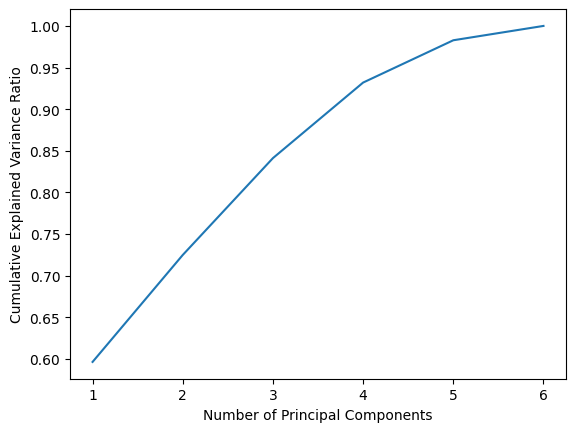

In [2]:
from sklearn.decomposition import PCA
import pandas as pd

var_threshold = 0.01
variances = dataset_train.iloc[:, :-4].var()
low_var_cols = variances[variances < var_threshold].index.tolist()
print(low_var_cols)

dataset_train = dataset_train.drop(columns=low_var_cols, axis=1)
dataset_test = dataset_test.drop(columns=low_var_cols, axis=1)

# creating a PCA object with n_components equal to the number of risk factors
pca = PCA(n_components=(dataset_train.shape[1] - 4))
pca.fit_transform(dataset_train.iloc[:, :-4])
top_pcs = np.argsort(np.abs(pca.components_))
print(top_pcs)

# ploting the cumulative explained variance ratio
import matplotlib.pyplot as plt

plt.plot(range(1, dataset_train.shape[1] - 3), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()


# Data Balancing
- Balancing the data seperately for each target variable using SMOTE

In [3]:
import pandas as pd
from imblearn.over_sampling import SMOTE


dataset_train_balanced = []
# Separating the features and target variables
X = dataset_train.iloc[:, :-4]
y_bio = dataset_train.iloc[:, -1]
y_cyt = dataset_train.iloc[:, -2]
y_sch = dataset_train.iloc[:, -3]
y_hin = dataset_train.iloc[:, -4]

# Balancing the datasets using SMOTE
smote = SMOTE(k_neighbors=1)
X_bio_resampled, y_bio_resampled = smote.fit_resample(X, y_bio)
X_cyt_resampled, y_cyt_resampled = smote.fit_resample(X, y_cyt)
X_sch_resampled, y_sch_resampled = smote.fit_resample(X, y_sch)
X_hin_resampled, y_hin_resampled = smote.fit_resample(X, y_hin)

# Combining the resampled data into new balanced datasets
dataset_train_bio_balanced = pd.concat(
    [pd.DataFrame(X_bio_resampled), pd.DataFrame(y_bio_resampled)], axis=1
)
dataset_train_cyt_balanced = pd.concat(
    [pd.DataFrame(X_cyt_resampled), pd.DataFrame(y_cyt_resampled)], axis=1
)
dataset_train_sch_balanced = pd.concat(
    [pd.DataFrame(X_sch_resampled), pd.DataFrame(y_sch_resampled)], axis=1
)
dataset_train_hin_balanced = pd.concat(
    [pd.DataFrame(X_hin_resampled), pd.DataFrame(y_hin_resampled)], axis=1
)

dataset_train_balanced.append(dataset_train_bio_balanced)
dataset_train_balanced.append(dataset_train_cyt_balanced)
dataset_train_balanced.append(dataset_train_sch_balanced)
dataset_train_balanced.append(dataset_train_hin_balanced)

for i in range(4):
    print(dataset_train_balanced[i].shape)
print(X.shape)


(610, 7)
(608, 7)
(594, 7)
(608, 7)
(317, 6)


# Data Visualization
- Plotting BoxPlot and Correlated Heatmap

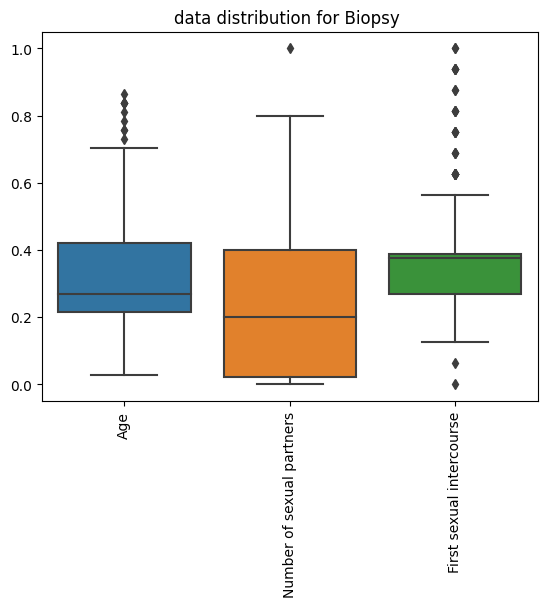

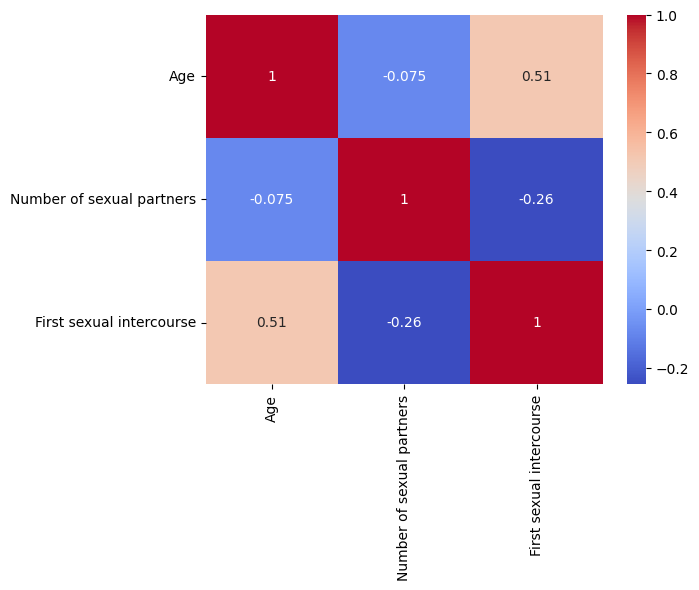

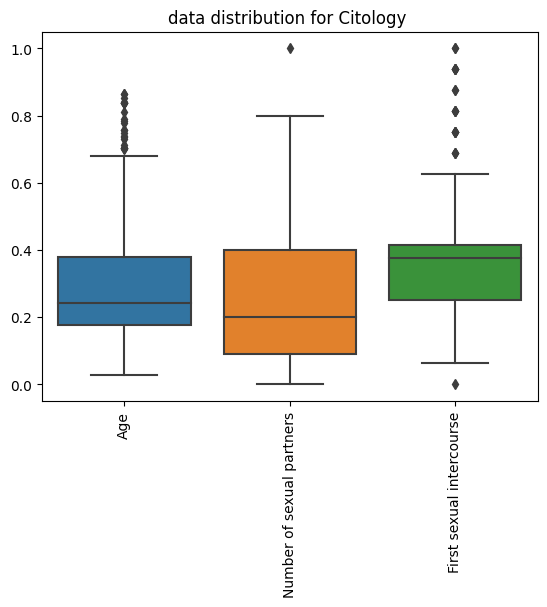

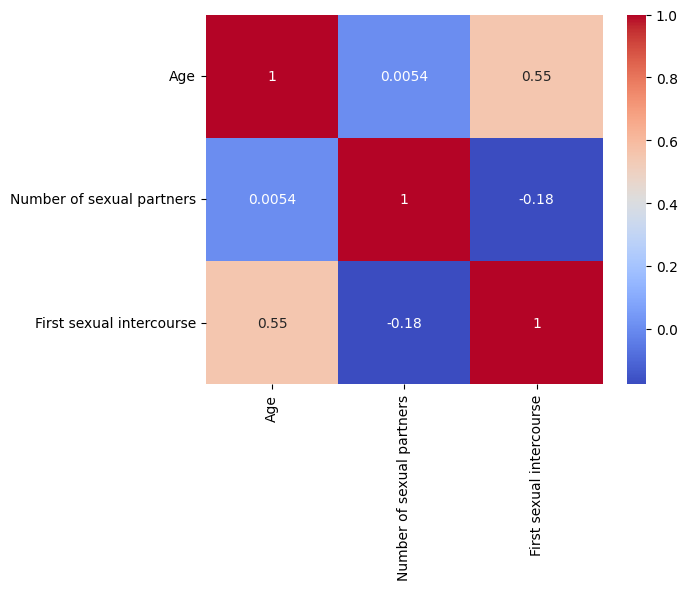

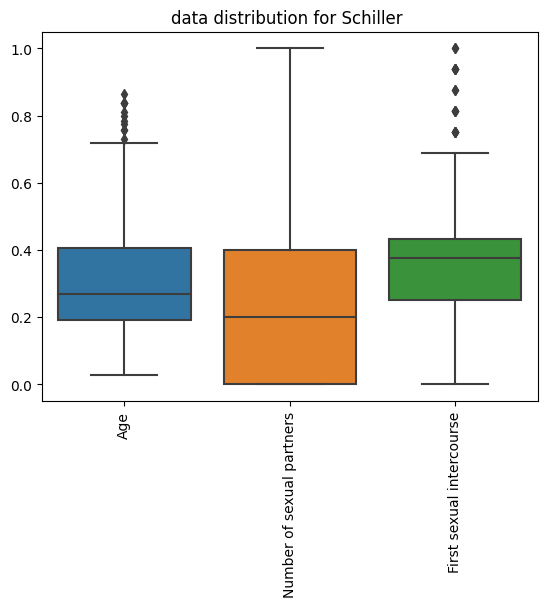

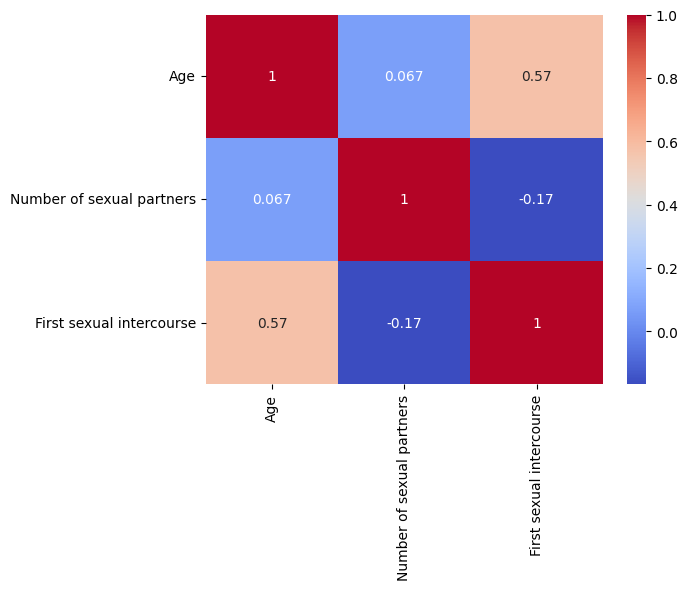

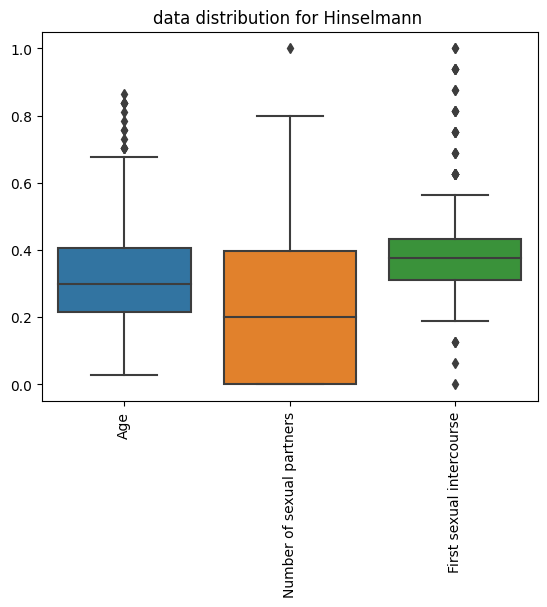

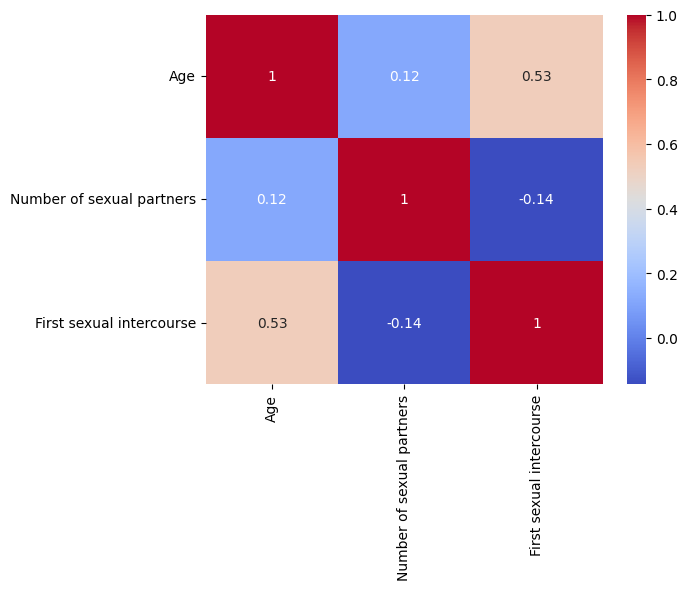

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(4):
    # Visualize the normalized data distribution using boxplot
    sns.boxplot(data=dataset_train_balanced[i].iloc[:, :-4])
    plt.xticks(rotation=90)
    plt.title(f"data distribution for {dataset_test.columns[-i-1]} ")
    plt.show()

    # Identify correlated features using correlation heatmap
    corr_matrix = dataset_train_balanced[i].iloc[:, :-4].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.show()


# Classifiers
- Classifying using SVM amd KNN

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Train and evaluate an SVM classifier
svm_clf = SVC(kernel="poly", C=1000)
y_pred_svm = []
for i in range(4):
    X = dataset_train_balanced[i]
    x = X.iloc[:, :-1]
    y = X.iloc[:, -1]
    svm_clf.fit(x, y.values.ravel())
    y_pred_svm.append(svm_clf.predict(dataset_test.iloc[:, :-4]))


# Train and evaluate a KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=6)
y_pred_knn = []
for i in range(4):
    X = dataset_train_balanced[i]
    x = X.iloc[:, :-1]
    y = X.iloc[:, -1]
    knn_clf.fit(x, y.values.ravel())
    y_pred_knn.append(knn_clf.predict(dataset_test.iloc[:, :-4]))


# Evaluation
- Printing Confusion Matrix for every Target Variable
- Tabulating Accuracy , Precision , Recall

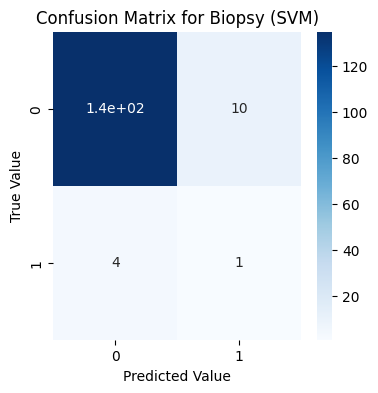

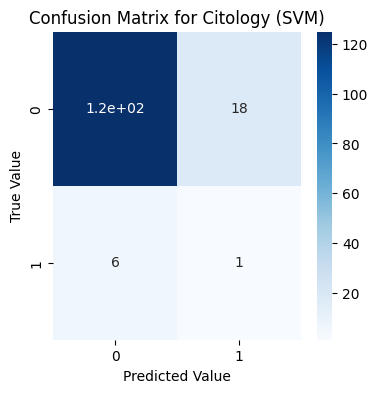

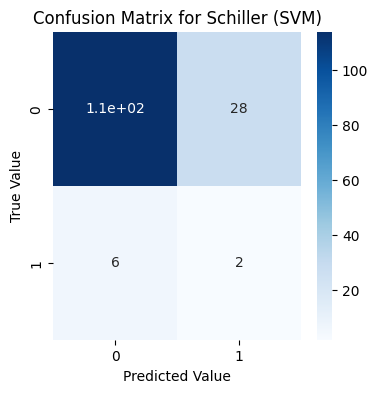

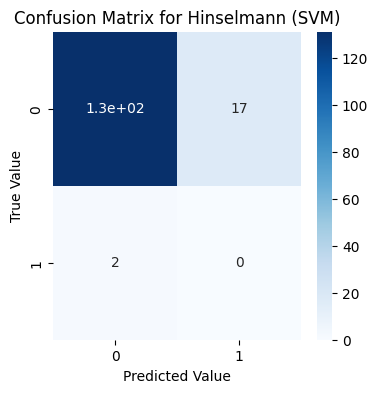

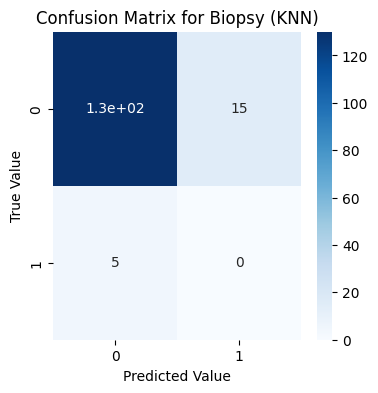

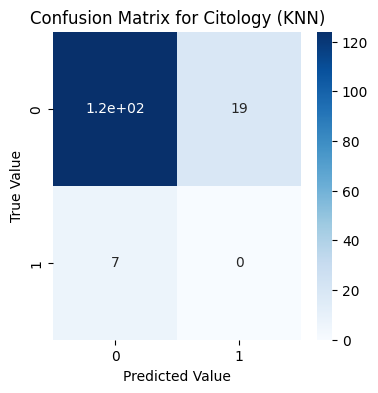

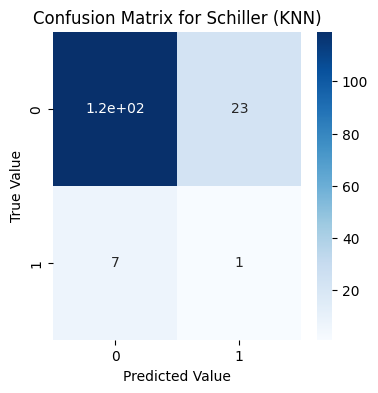

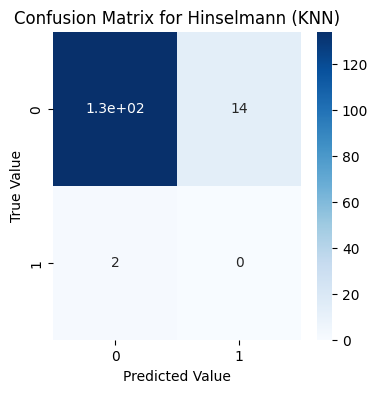

Evaluation Results:
-------------------
Target Variable               SVM Accuracy   SVM Precision  SVM Recall     KNN Accuracy   KNN Precision  KNN Recall     
Biopsy                        0.91           0.09           0.20           0.87           0.00           0.00           
Citology                      0.84           0.05           0.14           0.83           0.00           0.00           
Schiller                      0.77           0.07           0.25           0.80           0.04           0.12           
Hinselmann                    0.87           0.00           0.00           0.89           0.00           0.00           


In [6]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Evaluate SVM on each target variable
svm_metrics = []
for i in range(1, 5):
    accuracy = accuracy_score(dataset_test.iloc[:, -i], y_pred_svm[i - 1])
    precision = precision_score(dataset_test.iloc[:, -i], y_pred_svm[i - 1])
    recall = recall_score(dataset_test.iloc[:, -i], y_pred_svm[i - 1])
    svm_metrics.append([accuracy, precision, recall])
    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        confusion_matrix(dataset_test.iloc[:, -i], y_pred_svm[i - 1]),
        annot=True,
        cmap="Blues",
    )
    plt.title(f"Confusion Matrix for {dataset_test.columns[-i]} (SVM)")
    plt.ylabel("True Value")
    plt.xlabel("Predicted Value")
    plt.show()

# Evaluate KNN on each target variable
knn_metrics = []
for i in range(1, 5):
    accuracy = accuracy_score(dataset_test.iloc[:, -i], y_pred_knn[i - 1])
    precision = precision_score(dataset_test.iloc[:, -i], y_pred_knn[i - 1])
    recall = recall_score(dataset_test.iloc[:, -i], y_pred_knn[i - 1])
    knn_metrics.append([accuracy, precision, recall])
    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        confusion_matrix(dataset_test.iloc[:, -i], y_pred_knn[i - 1]),
        annot=True,
        cmap="Blues",
    )
    plt.title(f"Confusion Matrix for {dataset_test.columns[-i]} (KNN)")
    plt.ylabel("True Value")
    plt.xlabel("Predicted Value")
    plt.show()

# Print evaluation results in a table
print("Evaluation Results:")
print("-------------------")
print(
    "{:<30}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}".format(
        "Target Variable",
        "SVM Accuracy",
        "SVM Precision",
        "SVM Recall",
        "KNN Accuracy",
        "KNN Precision",
        "KNN Recall",
    )
)
for i in range(1, 5):
    print(
        "{:<30}{:<15.2f}{:<15.2f}{:<15.2f}{:<15.2f}{:<15.2f}{:<15.2f}".format(
            dataset_test.columns[-i],
            svm_metrics[i - 1][0],
            svm_metrics[i - 1][1],
            svm_metrics[i - 1][2],
            knn_metrics[i - 1][0],
            knn_metrics[i - 1][1],
            knn_metrics[i - 1][2],
        )
    )
